In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import statsmodels.api as sm
from sklearn.metrics import classification_report
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [52]:
def encode_column(df, column_name):
    # Inicializamos el LabelEncoder
    le = LabelEncoder()
    
    # Aplicamos el encoding en la columna y almacenamos las clases para futuros usos}
    df[column_name+"_le"] = le.fit_transform(df[column_name])
    
    # Retornamos el dataframe y el LabelEncoder para transformaciones futuras
    return df, le

In [53]:
def encode_top_n(df, column_name, top_n=10):
    # Obtiene los top_n valores más frecuentes
    top_values = df[column_name].value_counts().nlargest(top_n).index
    
    # Reemplaza los valores menos frecuentes por 'otros'
    df[column_name] = df[column_name].apply(lambda x: x if x in top_values else "otros")
    df[column_name] = df[column_name].astype(str)
    # Aplica el LabelEncoder
    return df

In [123]:
def proces_data(df):

    numerical_vars = ["emi_amount", "age", "loan_term", 'cibil_score', 'irr', "requested_amount","disbursed", 'segment_le', 'applicant_postal_code_le']
    categorical_vars = ["applicant_postal_code", "product_line", "segment"]

    df["applicant_postal_code"] = df["applicant_postal_code"].str.split(".").str[0].str.strip()
    df["applicant_postal_code"] = pd.to_numeric(df["applicant_postal_code"], errors="coerce").astype("Int64")

    df = encode_top_n(df, "applicant_postal_code", top_n=10)
    df, le_postal_code = encode_column(df, "applicant_postal_code")

    df = encode_top_n(df, "product_line", top_n=10)
    df, le_product = encode_column(df, "product_line")

    df = encode_top_n(df, "segment", top_n=5)
    df, le_segment = encode_column(df, "segment")

    
    df["age"] = df["age"].astype(int)

    df_num = df[numerical_vars]

    # Convertimos las variables categóricas nominales a variables dummy
    df_applicant_posta_code = pd.get_dummies(df['applicant_postal_code_le'], prefix='postal_code')
    df_applicant_posta_code = df_applicant_posta_code.astype(int)

    # Convertimos las variables categóricas nominales a variables dummy
    df_product = pd.get_dummies(df['product_line_le'], prefix='product')
    df_product = df_product.astype(int)

    # Convertimos las variables categóricas nominales a variables dummy
    df_segment = pd.get_dummies(df['segment_le'], prefix='segment')
    df_segment = df_segment.astype(int)

    # Unimos los dataframe incluyendo las variables dummy
    df_final_transform = pd.merge(df_num, df_applicant_posta_code, left_index=True, right_index=True)
    df_final_transform = pd.merge(df_final_transform, df_product, left_index=True, right_index=True)
    df_final_transform = pd.merge(df_final_transform, df_segment, left_index=True, right_index=True)

    df_final_transform["cibil_score"] = np.where(df_final_transform["cibil_score"]<1, 1, df_final_transform["cibil_score"])

    df_final_transform['emi_amount_log'] = np.log(df_final_transform['emi_amount'])
    df_final_transform['age_log'] = np.log(df_final_transform['age'])
    df_final_transform['loan_term_log'] = np.log(df_final_transform['loan_term'])
    df_final_transform['cibil_score_log'] = np.log(df_final_transform['cibil_score'])
    df_final_transform['irr_log'] = np.log(df_final_transform['irr'])

    return df_final_transform

In [124]:
def fit_logit_model(df, variables_x, variables_y):
    Y = df[variables_y]
    X = df[variables_x]
    X = sm.add_constant(X, prepend=False)

    model_logit = sm.Logit(endog=Y, exog=X).fit()
    print(model_logit.summary())

    Y_pred = model_logit.predict(X).round(0).astype(int)
    # Reporte de métricas
    reporte = classification_report(Y, Y_pred, labels=[1, 0])
    print("Reporte de clasificación:\n", reporte)
    return model_logit

In [125]:
df = pd.read_pickle("../output/base_etapa_1.pkl")

In [126]:
df_process = proces_data(df)

In [127]:
df_process.corr()[["disbursed"]].sort_values(by=["disbursed"]).head(10)

,disbursed
irr_log,-0.632865
irr,-0.621878
loan_term,-0.058891
loan_term_log,-0.051708
product_2,-0.044242
segment_le,-0.033323
product_9,-0.030676
product_7,-0.028664
requested_amount,-0.023113
postal_code_10,-0.021293


In [128]:
df_process.corr()[["disbursed"]].sort_values(by=["disbursed"]).tail(10)

,disbursed
cibil_score_log,0.012544
postal_code_3,0.014474
postal_code_9,0.028166
cibil_score,0.031909
segment_0,0.035241
postal_code_2,0.035585
age,0.035676
age_log,0.036669
product_10,0.069544
disbursed,1.000000


In [142]:
variables_x = ["irr_log", 'loan_term_log', 'age_log', 'segment_le']
variables_y = "disbursed"

In [143]:
model_general = fit_logit_model(df_process, variables_x, variables_y)

Optimization terminated successfully.
         Current function value: 0.428413
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              disbursed   No. Observations:                12055
Model:                          Logit   Df Residuals:                    12050
Method:                           MLE   Df Model:                            4
Date:                Wed, 30 Oct 2024   Pseudo R-squ.:                  0.3772
Time:                        23:56:40   Log-Likelihood:                -5164.5
converged:                       True   LL-Null:                       -8292.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
irr_log         -15.8355      0.303    -52.299      0.000     -16.429     -15.242
loan_term_log    -0.

In [144]:
df_process['const'] = 1.0
df_process['prob_T1'] = model_general.predict(df_process[variables_x + ["const"]])
df_process["coef_irr_log"] = model_general.params["irr_log"]
df_process["elasticidad"] = df_process["coef_irr_log"] * (1-df_process["prob_T1"])/(1-df_process["irr_log"])

In [145]:
df_process.to_pickle("../output/base_etapa_2.pkl")

## Analisis de probabilidad de aceptacion

In [146]:
df_process[["irr", "loan_term", "age"]].describe()

,irr,loan_term,age
count,12055.000000,12055.000000,12055.000000
mean,19.843160,43.582829,38.009954
std,2.956696,11.071337,9.743316
min,16.500000,11.000000,18.000000
25%,17.400000,36.000000,30.000000
50%,18.600000,36.000000,37.000000
75%,22.200000,48.000000,44.000000
max,26.500000,60.000000,69.000000


In [147]:
df_process[variables_x].mean()

irr_log          2.977385
loan_term_log    3.740782
age_log          3.605819
segment_le       1.248196
dtype: float64

In [148]:
rango_irr = np.arange(17, 27, 0.1)
df_simulacion = pd.DataFrame(rango_irr)
df_simulacion = df_simulacion.rename({0: 'irr'}, axis=1)
df_simulacion["emi_amount"] = 12200
df_simulacion["age"] = 37
df_simulacion["loan_term"] = 42
df_simulacion['emi_amount_log'] = np.log(df_simulacion['emi_amount'])
df_simulacion['age_log'] = np.log(df_simulacion['age'])
df_simulacion['irr_log'] = np.log(df_simulacion['irr'])
df_simulacion['loan_term_log'] = np.log(df_simulacion['loan_term'])
df_simulacion["segment_le"] = 1
df_simulacion["applicant_postal_code_le"] = 20
df_simulacion['const'] = 1.0
df_simulacion["coef_irr"] = -15.8723
df_simulacion['prob_T1'] = model_general.predict(df_simulacion[variables_x + ["const"]])
df_simulacion["elasticidad"] = df_simulacion["coef_irr"] * (1-df_simulacion["prob_T1"])/(1-df_simulacion["irr_log"])

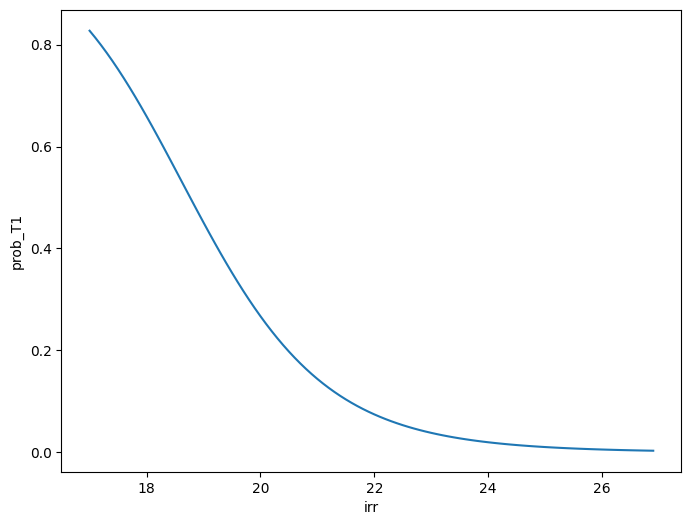

In [149]:
# Create a figure and axis
plt.figure(figsize=(8, 6))
# Plot the line
sns.lineplot(x='irr', y='prob_T1', data=df_simulacion)
# Display the plot
plt.show()

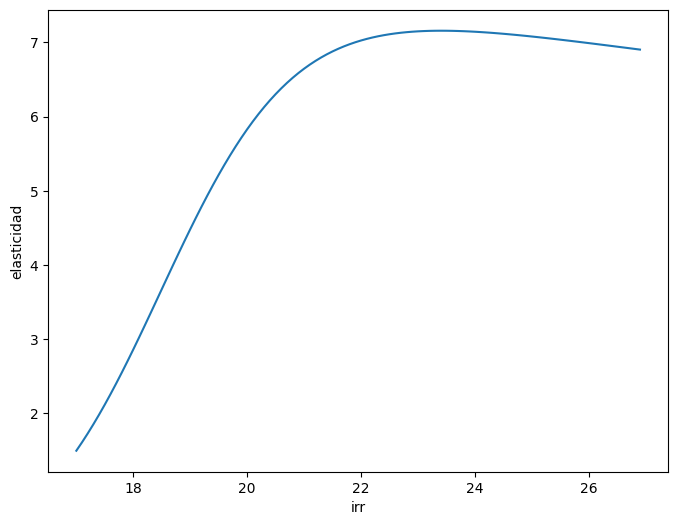

In [150]:
# Create a figure and axis
plt.figure(figsize=(8, 6))
# Plot the line
sns.lineplot(x='irr', y='elasticidad', data=df_simulacion)
# Display the plot
plt.show()

In [151]:
df_process.groupby(by=["segment_le"]).agg({'elasticidad':'mean'})

,elasticidad
segment_le,
0,4.151333
1,4.247667
2,4.254978
3,4.383692
4,4.479154
5,4.612045
